### We will follow the general steps to perform style transfer:

1. Visualize data
2. Basic Preprocessing/preparing our data
3. Set up loss functions
4. Create model
5. Optimize for loss function

### Import and configure modules

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [2]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras import backend as K

We’ll begin by enabling [eager execution](https://www.tensorflow.org/guide/eager). Eager execution allows us to work through this technique in the clearest and most readable way.

In [3]:
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


Please upload a style and content image pair, located in the images directory.

In [48]:
# Set up some global values here
from google.colab import files
uploaded = files.upload()
content_path = '1c.png'
style_path = '1s.jpg'

## Visualize the input

In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)

  img = kp_image.img_to_array(img)

  # We need to broadcast the image array such that it has a batch dimension
  img = np.expand_dims(img, axis=0)
  return img

In [6]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

In [7]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

<ipython-input-5-a1d0181f799d>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)


## Prepare the data
We load and prepocess the data the same way as is done by VGG. VGG networks are trained on image with each channel normalized by `mean = [103.939, 116.779, 123.68]` and with channels BGR. This is also the case for ResNet50.

In [8]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.resnet50.preprocess_input(img)
  return img

In [9]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")

  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

### Define content and style representations

Now we need to identify the intermediate layers whose output we will use for calculating our content and style loss functions. To do that we need to know how these layers are named in Keras.  The code block below allows us to see the names of the different layers in tResNet50.  Based on that we can select the specific layers we want for content and style.

In [10]:
resnet = tf.keras.applications.resnet50.ResNet50(weights='imagenet')
resnet.summary()

102967424/102967424 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

Now that we know how the layers are named, we select the ones we want to use. This is done by trial and error. Do not select any layers that have no parameters.
*   **For content layers:** Generally, one layer for content seems to work fine.
*   **For style layers:** Identify the layers that work best for style transfer. I started using a single style layer to see if that layer, after running say 500 iteration, would translate any stlyle to the generated image, and if so how apealing that style was.  After doing this with several layers I selected the ones I liked best. The more layers are selected the longer it takes the optimization to run.  For this example we use 4 style layers.

Please note that when layer 'conv1' was included as a style layer, it dominated the optimization leading to a generated image that had all the colors of the style image but none of the distinctive patterns. For this reason, it is left out in the code block below.  This may be useful if there is an application where we want to tranfer the color only.


In [11]:
# Content layer where will pull our feature maps
content_layers = ['conv1_pad']

# Style layer we are interested in
style_layers = ['conv2_block2_1_bn','conv3_block1_2_bn','conv3_block1_0_conv','conv4_block5_1_bn'#,'conv1'
               ]
#['conv2_block1_0_bn','conv3_block1_1_conv','conv4_block6_2_conv','conv5_block3_2_bn'#,'conv1'

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In order to access the intermediate layers corresponding to our style and content feature maps, we get the corresponding outputs and using the Keras [**Functional API**](https://keras.io/getting-started/functional-api-guide/), we define our model with the desired output activations.

With the Functional API defining a model simply involves defining the input and output:

`model = Model(inputs, outputs)`

In [12]:
def get_model():
  """ Creates our model with access to intermediate layers.

  This function will load the ResNet50 model and access the intermediate layers.
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the ResNet50 model.

  Returns:
    returns a keras model that takes image inputs and outputs the style and
      content intermediate layers.
  """
  # Load our model. We load pretrained ResNet50, trained on imagenet data
  resnet = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
  resnet.trainable = False
  # Get output layers corresponding to style and content layers
  style_outputs = [resnet.get_layer(name).output for name in style_layers]
  content_outputs = [resnet.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model
  return models.Model(resnet.input, model_outputs)

## Define and create our loss functions (content and style distances)

### Content Loss

### Computing content loss
We will actually add our content losses at each desired layer. This way, each iteration when we feed our input image through the model (which in eager is simply `model(input_image)`!) all the content losses through the model will be properly compute and because we are executing eagerly, all the gradients will be computed.

In [13]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

## Style Loss

### Computing style loss
Again, we implement our loss as a distance metric .

In [14]:
def gram_matrix(input_tensor):
  # We make the image channels first
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)

  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

## Apply style transfer to our images


### Run Gradient Descent
In this case, we use the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer in order to minimize our loss. We iteratively update our output image such that it minimizes our loss: we don't update the weights associated with our network, but instead we train our input image to minimize loss. In order to do this, we must know how we calculate our loss and gradients.


We’ll define a little helper function that will load our content and style image, feed them forward through our network, which will then output the content and style feature representations from our model.

In [15]:
def get_feature_representations(model, content_path, style_path):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers.

  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image

  Returns:
    returns the style features and the content features.
  """
  # Load our images in
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)

  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)


  # Get the style and content feature representations from our model
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

### Computing the loss and gradients
Here we use [**tf.GradientTape**](https://www.tensorflow.org/programmers_guide/eager#computing_gradients) to compute the gradient. It allows us to take advantage of the automatic differentiation available by tracing operations for computing the gradient later. It records the operations during the forward pass and then is able to compute the gradient of our loss function with respect to our input image for the backwards pass.

In [16]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.

  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function.
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with
      our optimization process. We apply the gradients wrt the loss we are
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of
      interest.

  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  style_weight, content_weight = loss_weights

  # Feed our init image through our model. This will give us the content and
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)

  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]

  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

  # Accumulate content losses from all layers
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score
  return loss, style_score, content_score

Then computing the gradients is easy:

In [17]:
def compute_grads(cfg):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

### Optimization loop

The parameters used here are significantly different to those used for VGG nets. These were determined by trial an error, and will need to be adjusted by trial and error for each content-style pair.


In [51]:
import IPython.display

def run_style_transfer(content_path,
                       style_path,
                       num_iterations=1000,
                       content_weight=2,
                       style_weight=1e6):
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false.
  model = get_model()
  for layer in model.layers:
    layer.trainable = False

  # Get the style and content feature representations (from our specified intermediate layers)
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.keras.optimizers.Adam(learning_rate=12, beta_1=0.90, epsilon=1e-1)

  # Store our best result
  best_loss, best_img = float('inf'), None

  # Create a nice config
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }

  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()

  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means

  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time()

    print(". ", end="") # Fo tracking progress

    if loss < best_loss:
      # Update best loss and best image from total loss.
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()

      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))
      print('Total loss: {:.4e}, '
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])

  return best_img, best_loss

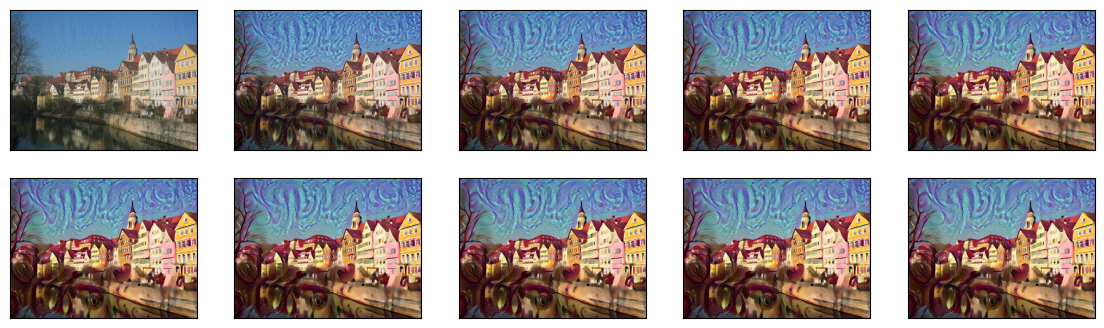

In [52]:
best, best_loss = run_style_transfer(content_path,
                                     style_path, num_iterations=1000)

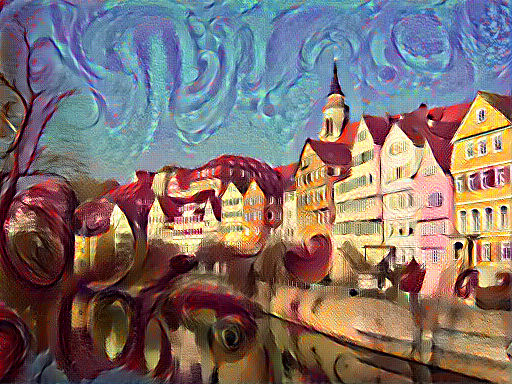

In [53]:
Image.fromarray(best)

In [54]:
Image.fromarray(best).save("out.jpg", "JPEG", quality=80, optimize=True, progressive=True)

# To download images from colab
from google.colab import files
files.download('out.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualize outputs
We "deprocess" the output image in order to remove the processing that was applied to it.

In [25]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path)
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final:
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

<ipython-input-5-a1d0181f799d>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)


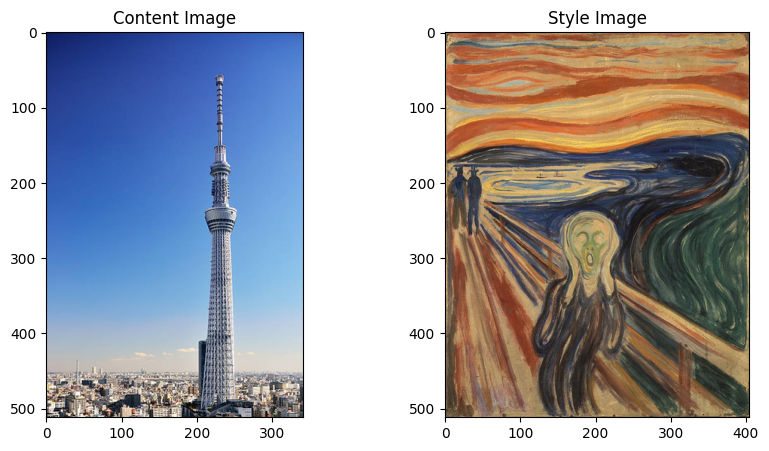

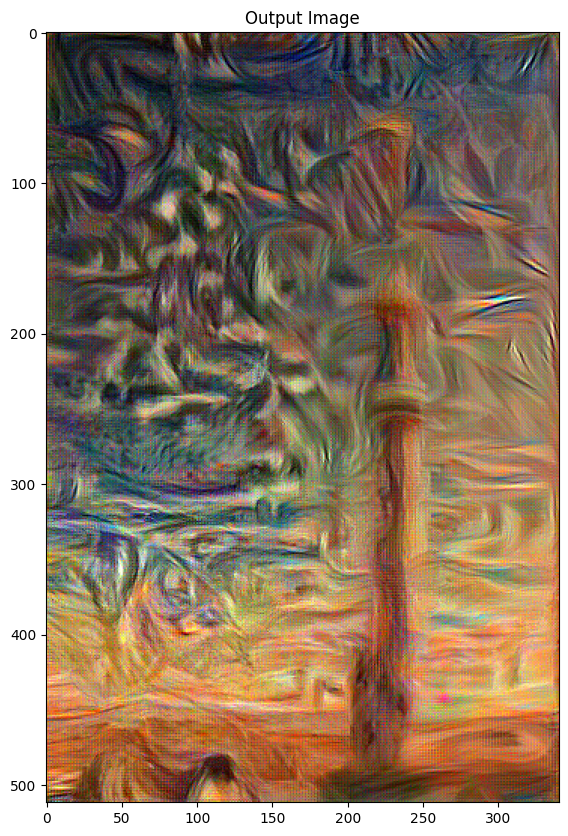

In [23]:
show_results(best, content_path, style_path)

## References
Leo Barbosa: https://github.com/Leo8216/Neural-Style-Transfer-using-ResNet50-with-tf.keras-/tree/master